In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
from sklearn.cluster import KMeans
import xarray as xr
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Converting the sliding scale to look at months instead of years

In [2]:
# Load the datasets
osc_data_monthly = xr.open_dataset('data_use/osc_idx.nc').to_dataframe()
GL_data = xr.open_dataset('data_use/GL_NCEP_gridded_air.nc')

#getting y labels:

#getting months of data
months = np.asarray(pd.to_datetime(GL_data.time).month)

#getting years
years = GL_data.groupby('time.year').mean().year[1:]

#getting only winter months (DJF), leaving out 1950
GL_winter = GL_data.air[np.where((months == 12) | (months == 1) | (months == 2))][2:]

#averaging annually, converting to numpy
GL_DJF = np.zeros((72, 5, 9))
for i in np.arange(72):
    GL_DJF[i] = GL_winter[3*i:3*(i+1)].mean('time').to_numpy()
    
#creating new DataArray
GL_DJF = xr.DataArray(
    data = GL_DJF,
    dims = ['year', 'lat', 'lon'],
    coords = dict(
        year = years,
        lat = GL_data.lat,
        lon = GL_data.lon
    )
)

#standardizing data
scaler = StandardScaler()
GL_DJF_stan = scaler.fit_transform(GL_DJF.to_numpy().reshape(72, 45))

#using KMeans with 2 clusters
kmeans2 = KMeans(n_clusters = 2, random_state = 42, n_init = 'auto')
kmeans2.fit(GL_DJF_stan)
y_labels = kmeans2.labels_
y_clusters2 = np.copy(y_labels)[1:]

In [3]:
# Creating a lagged dataset: The inputs will be the oscillation indices lagged up to 24 months
#creating lagged column names
lagged_cols = []
for i in np.arange(len(osc_data_monthly.columns)):
    for j in np.arange(12):
        lagged_cols.append(f'{osc_data_monthly.columns[i]}_lag{j}')

#lagging data
lagged_data = np.zeros((71, len(lagged_cols)))
for i in np.arange(71):
    for j in np.arange(10):
        lagged_data[i,12*j:12*(j+1)] = np.flip(osc_data_monthly[osc_data_monthly.columns[j]][12*i:(12*i + 12)].to_numpy())
#putting into a DataFrame
lagged_DF = pd.DataFrame(
    data = lagged_data,
    index = np.arange(1951, 2022),
    columns = lagged_cols
)

#standardizing
X_lagged = StandardScaler().fit_transform(lagged_DF)

#Align `y_clusters` with `X_lagged`
y_clusters = y_labels[1:]

In [4]:
#function to get metrics for models
def get_model_score(model, y_clusters, metric):
    #training size is 4 times testing size
    n_test = np.arange(2,10)
    n_train = 4*n_test
    
    #list for metrics
    results = []
    
    #looping throuhg different training and testing sizes
    for i in np.arange(len(n_test)):
        #using a sliding window: training will be first n_train data, then testing will be next n_ttest data
        overall_scores = []
        for start_idx in range(len(X_lagged) - n_train[i] - n_test[i]):
            #getting training and testing data
            X_train = X_lagged[start_idx:start_idx + n_train[i]]
            y_train = y_clusters[start_idx:start_idx + n_train[i]]
            X_test = X_lagged[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            y_test = y_clusters[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            
            #fitting model and making predictions
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            #getting metric and appending to results
            score = metric(y_test, y_pred)
            overall_scores.append(score)
        results.append(np.mean(overall_scores))
        
    return np.asarray(results)

In [5]:
#getting accuracy for 7 models
accuracy_LogReg = get_model_score(LogisticRegression(),y_clusters2, accuracy_score)
accuracy_HGBC = get_model_score(HistGradientBoostingClassifier(max_iter=200, random_state=42, learning_rate=0.001, class_weight='balanced'),y_clusters2, accuracy_score)
accuracy_Bagging = get_model_score(BaggingClassifier(), y_clusters2, accuracy_score)
accuracy_RandForest = get_model_score(RandomForestClassifier(), y_clusters2, accuracy_score)
accuracy_Ridge = get_model_score(RidgeClassifier(), y_clusters2, accuracy_score)
accuracy_Lasso = get_model_score(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), y_clusters2, accuracy_score)
accuracy_Tree = get_model_score(DecisionTreeClassifier(max_depth=3), y_clusters2, accuracy_score)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [6]:
#getting precision for 7 models
precision_LogReg = get_model_score(LogisticRegression(),y_clusters2, precision_score)
precision_HGBC = get_model_score(HistGradientBoostingClassifier(max_iter=200, random_state=42, learning_rate=0.001, class_weight='balanced'),y_clusters2, precision_score)
precision_Bagging = get_model_score(BaggingClassifier(), y_clusters2, precision_score)
precision_RandForest = get_model_score(RandomForestClassifier(), y_clusters2, precision_score)
precision_Ridge = get_model_score(RidgeClassifier(), y_clusters2, precision_score)
precision_Lasso = get_model_score(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), y_clusters2, precision_score)
precision_Tree = get_model_score(DecisionTreeClassifier(max_depth=3), y_clusters2, precision_score)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

In [7]:
#getting recall for 7 models
recall_LogReg = get_model_score(LogisticRegression(),y_clusters2, recall_score)
recall_HGBC = get_model_score(HistGradientBoostingClassifier(max_iter=200, random_state=42, learning_rate=0.001, class_weight='balanced'),y_clusters2, recall_score)
recall_Bagging = get_model_score(BaggingClassifier(), y_clusters2, recall_score)
recall_RandForest = get_model_score(RandomForestClassifier(), y_clusters2, recall_score)
recall_Ridge = get_model_score(RidgeClassifier(), y_clusters2, recall_score)
recall_Lasso = get_model_score(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), y_clusters2, recall_score)
recall_Tree = get_model_score(DecisionTreeClassifier(max_depth=3), y_clusters2, recall_score)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedM

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedM

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedM

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedM

In [8]:
#getting f1 score for 7 models
f1_LogReg = get_model_score(LogisticRegression(),y_clusters2, f1_score)
f1_HGBC = get_model_score(HistGradientBoostingClassifier(max_iter=200, random_state=42, learning_rate=0.001, class_weight='balanced'),y_clusters2, f1_score)
f1_Bagging = get_model_score(BaggingClassifier(), y_clusters2, f1_score)
f1_RandForest = get_model_score(RandomForestClassifier(), y_clusters2, f1_score)
f1_Ridge = get_model_score(RidgeClassifier(), y_clusters2, f1_score)
f1_Lasso = get_model_score(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), y_clusters2, f1_score)
f1_Tree = get_model_score(DecisionTreeClassifier(max_depth=3), y_clusters2, f1_score)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dze

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dze

In [9]:
#function to get metrics for null model
def get_null_score(y_clusters, metric):
    n_test = np.arange(2,10)
    n_train = 4*n_test
    
    results = []
    for i in np.arange(len(n_test)):
        overall_scores = []
        for start_idx in range(len(X_lagged) - n_train[i] - n_test[i]):
            X_train = X_lagged[start_idx:start_idx + n_train[i]]
            y_train = y_clusters[start_idx:start_idx + n_train[i]]
            X_test = X_lagged[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            y_test = y_clusters[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            
            #using most frequent class in training dataset
            most_freq = np.argmax(np.bincount(y_train))
            y_pred = most_freq*np.ones_like(y_test)

            score = metric(y_test, y_pred)
            overall_scores.append(score)
        results.append(np.mean(overall_scores))
        
    return np.asarray(results)

In [10]:
#getting null scores
null_accuracy = get_null_score(y_clusters2, accuracy_score)
null_precision = get_null_score(y_clusters2, precision_score)
null_recall = get_null_score(y_clusters2, recall_score)
null_f1 = get_null_score(y_clusters2, f1_score)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/dze

In [11]:
n_test = np.arange(2,10)
n_train = 4*n_test

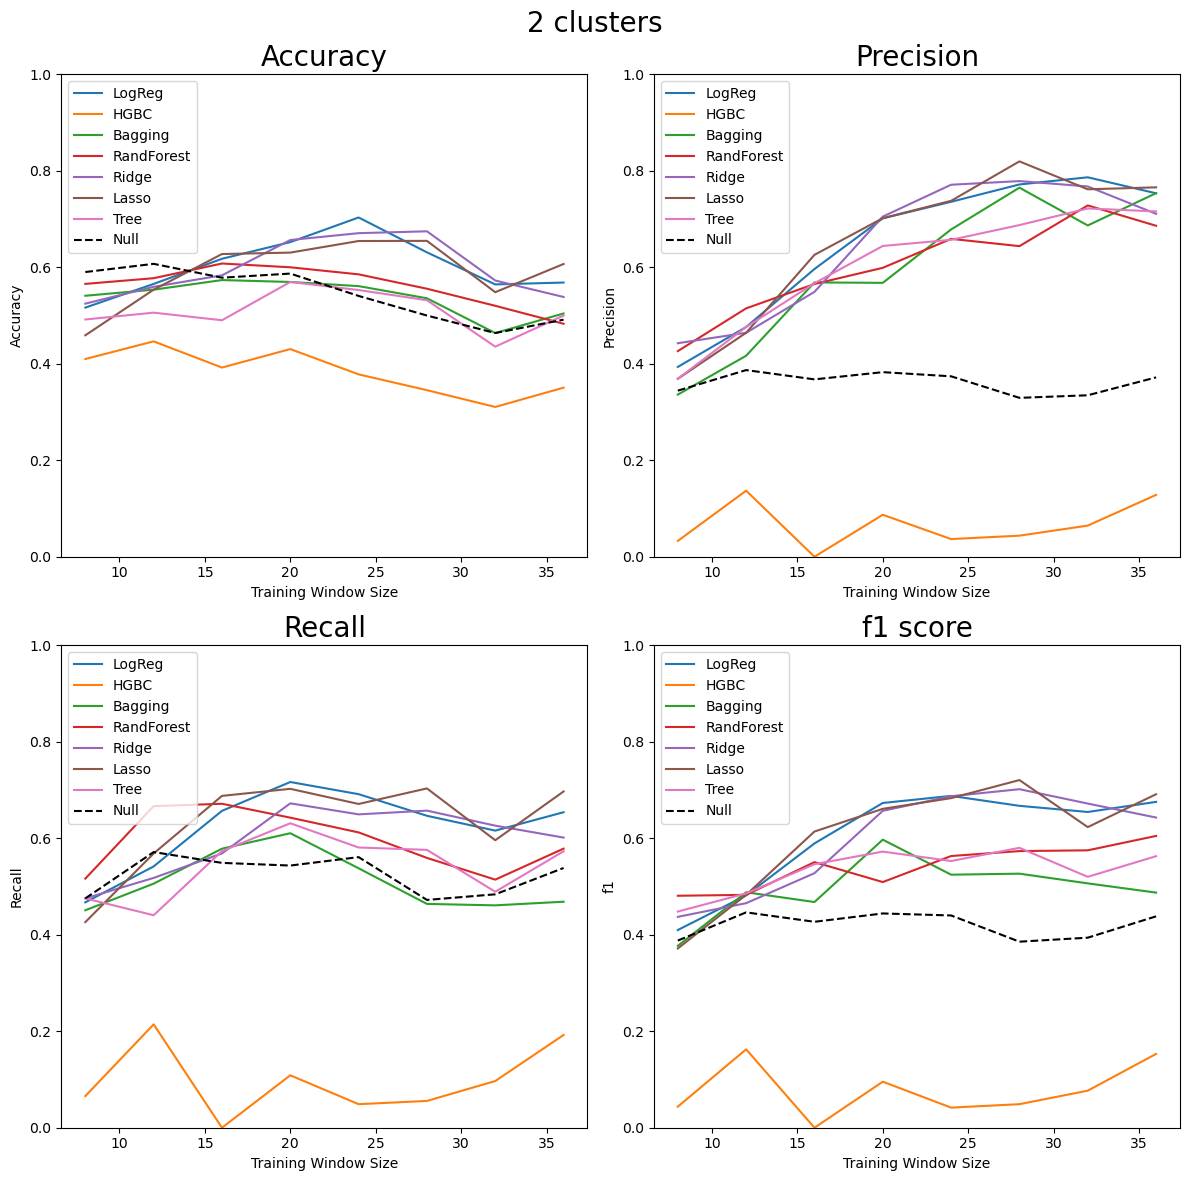

In [12]:
#plotting
fig, ax = plt.subplots(2,2, figsize = (12, 12))
ax[0,0].plot(n_train, accuracy_LogReg, label = 'LogReg')
ax[0,0].plot(n_train, accuracy_HGBC, label = 'HGBC')
ax[0,0].plot(n_train, accuracy_Bagging, label = 'Bagging')
ax[0,0].plot(n_train, accuracy_RandForest, label = 'RandForest')
ax[0,0].plot(n_train, accuracy_Ridge, label = 'Ridge')
ax[0,0].plot(n_train, accuracy_Lasso, label = 'Lasso')
ax[0,0].plot(n_train, accuracy_Tree, label = 'Tree')
ax[0,0].plot(n_train, null_accuracy, c = 'k', ls = '--', label = 'Null')
ax[0,0].legend()
ax[0,0].set_xlabel('Training Window Size')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_ylim(0,1)
ax[0,0].set_title('Accuracy', fontsize = 20)


ax[0,1].plot(n_train, precision_LogReg, label = 'LogReg')
ax[0,1].plot(n_train, precision_HGBC, label = 'HGBC')
ax[0,1].plot(n_train, precision_Bagging, label = 'Bagging')
ax[0,1].plot(n_train, precision_RandForest, label = 'RandForest')
ax[0,1].plot(n_train, precision_Ridge, label = 'Ridge')
ax[0,1].plot(n_train, precision_Lasso, label = 'Lasso')
ax[0,1].plot(n_train, precision_Tree, label = 'Tree')
ax[0,1].plot(n_train, null_precision, c = 'k', ls = '--', label = 'Null')
ax[0,1].legend()
ax[0,1].set_xlabel('Training Window Size')
ax[0,1].set_ylabel('Precision')
ax[0,1].set_ylim(0,1)
ax[0,1].set_title('Precision', fontsize = 20)

ax[1,0].plot(n_train, recall_LogReg, label = 'LogReg')
ax[1,0].plot(n_train, recall_HGBC, label = 'HGBC')
ax[1,0].plot(n_train, recall_Bagging, label = 'Bagging')
ax[1,0].plot(n_train, recall_RandForest, label = 'RandForest')
ax[1,0].plot(n_train, recall_Ridge, label = 'Ridge')
ax[1,0].plot(n_train, recall_Lasso, label = 'Lasso')
ax[1,0].plot(n_train, recall_Tree, label = 'Tree')
ax[1,0].plot(n_train, null_recall, c = 'k', ls = '--', label = 'Null')
ax[1,0].legend()
ax[1,0].set_xlabel('Training Window Size')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0,1)
ax[1,0].set_title('Recall', fontsize = 20)

ax[1,1].plot(n_train, f1_LogReg, label = 'LogReg')
ax[1,1].plot(n_train, f1_HGBC, label = 'HGBC')
ax[1,1].plot(n_train, f1_Bagging, label = 'Bagging')
ax[1,1].plot(n_train, f1_RandForest, label = 'RandForest')
ax[1,1].plot(n_train, f1_Ridge, label = 'Ridge')
ax[1,1].plot(n_train, f1_Lasso, label = 'Lasso')
ax[1,1].plot(n_train, f1_Tree, label = 'Tree')
ax[1,1].plot(n_train, null_f1, c = 'k', ls = '--', label = 'Null')
ax[1,1].legend()
ax[1,1].set_xlabel('Training Window Size')
ax[1,1].set_ylabel('f1')
ax[1,1].set_ylim(0,1)
ax[1,1].set_title('f1 score', fontsize = 20)

plt.suptitle('2 clusters', fontsize = 20)
plt.tight_layout()
plt.savefig('2cluster_metric_plots.png')

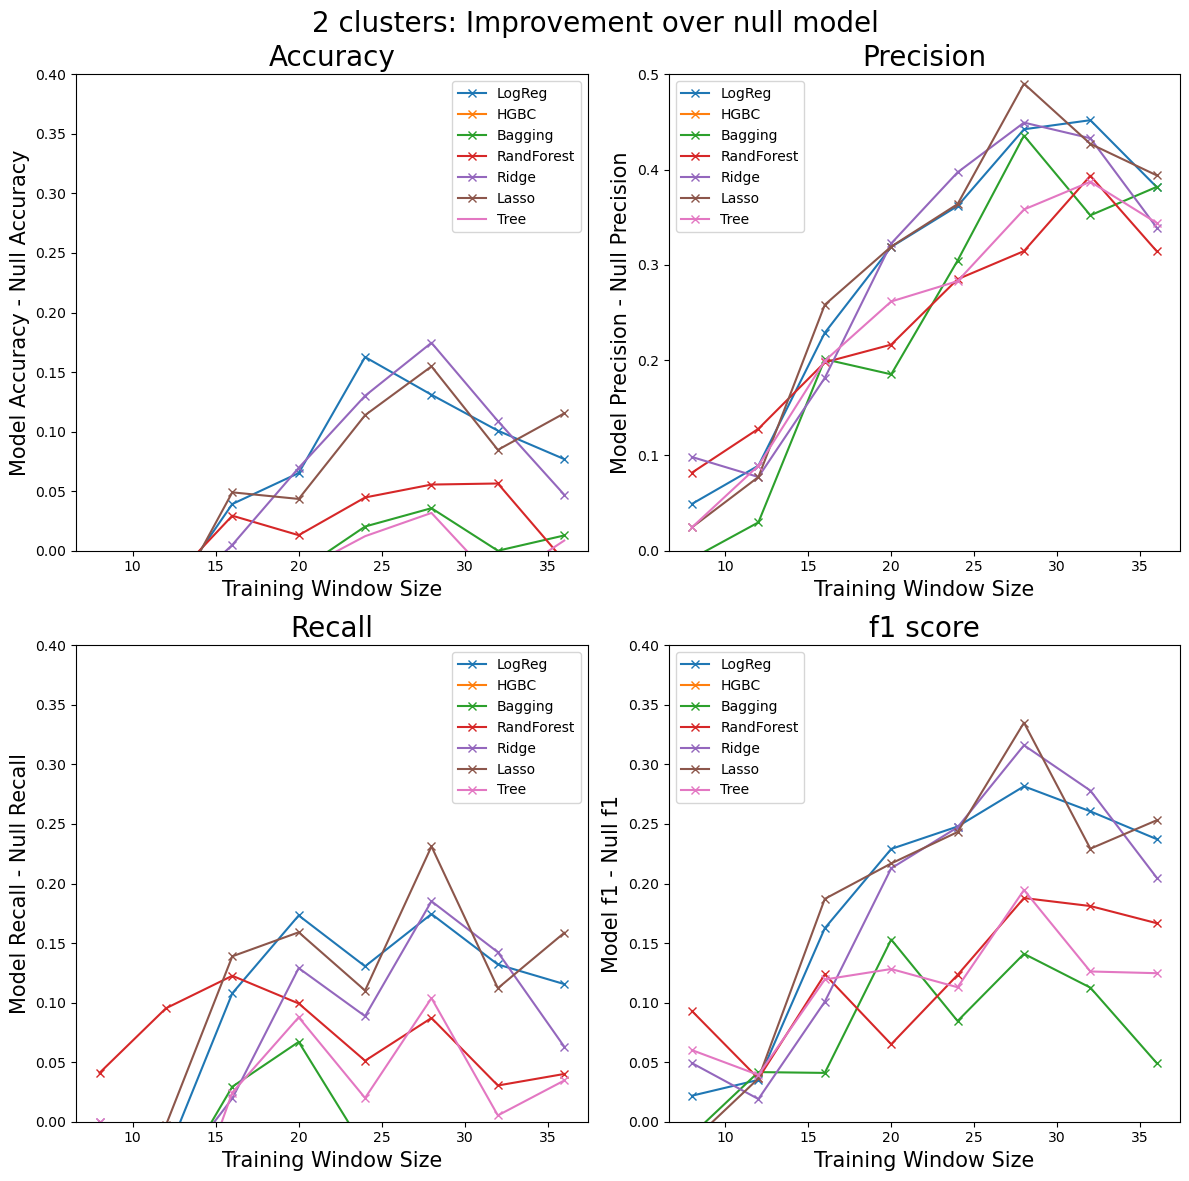

In [13]:
#plotting
fig, ax = plt.subplots(2,2, figsize = (12, 12))
ax[0,0].plot(n_train, accuracy_LogReg - null_accuracy, label = 'LogReg', marker = 'x')
ax[0,0].plot(n_train, accuracy_HGBC - null_accuracy, label = 'HGBC', marker = 'x')
ax[0,0].plot(n_train, accuracy_Bagging - null_accuracy, label = 'Bagging', marker = 'x')
ax[0,0].plot(n_train, accuracy_RandForest - null_accuracy, label = 'RandForest', marker = 'x')
ax[0,0].plot(n_train, accuracy_Ridge - null_accuracy, label = 'Ridge', marker = 'x')
ax[0,0].plot(n_train, accuracy_Lasso - null_accuracy, label = 'Lasso', marker = 'x')
ax[0,0].plot(n_train, accuracy_Tree - null_accuracy, label = 'Tree')
#ax[0,0].plot(n_train, null_accuracy, c = 'k', ls = '--', label = 'Null')
ax[0,0].legend()
ax[0,0].set_xlabel('Training Window Size', fontsize = 15)
ax[0,0].set_ylabel('Model Accuracy - Null Accuracy', fontsize = 15)
ax[0,0].set_ylim(0,0.4)
ax[0,0].set_title('Accuracy', fontsize = 20)


ax[0,1].plot(n_train, precision_LogReg - null_precision, label = 'LogReg', marker = 'x')
ax[0,1].plot(n_train, precision_HGBC - null_precision, label = 'HGBC', marker = 'x')
ax[0,1].plot(n_train, precision_Bagging - null_precision, label = 'Bagging', marker = 'x')
ax[0,1].plot(n_train, precision_RandForest - null_precision, label = 'RandForest', marker = 'x')
ax[0,1].plot(n_train, precision_Ridge - null_precision, label = 'Ridge', marker = 'x')
ax[0,1].plot(n_train, precision_Lasso - null_precision, label = 'Lasso', marker = 'x')
ax[0,1].plot(n_train, precision_Tree - null_precision, label = 'Tree', marker = 'x')
#ax[0,1].plot(n_train, null_precision, c = 'k', ls = '--', label = 'Null')
ax[0,1].legend()
ax[0,1].set_xlabel('Training Window Size', fontsize = 15)
ax[0,1].set_ylabel('Model Precision - Null Precision', fontsize = 15)
ax[0,1].set_ylim(0,0.5)
ax[0,1].set_title('Precision', fontsize = 20)

ax[1,0].plot(n_train, recall_LogReg - null_recall, label = 'LogReg', marker = 'x')
ax[1,0].plot(n_train, recall_HGBC - null_recall, label = 'HGBC', marker = 'x')
ax[1,0].plot(n_train, recall_Bagging - null_recall, label = 'Bagging', marker = 'x')
ax[1,0].plot(n_train, recall_RandForest - null_recall, label = 'RandForest', marker = 'x')
ax[1,0].plot(n_train, recall_Ridge - null_recall, label = 'Ridge', marker = 'x')
ax[1,0].plot(n_train, recall_Lasso - null_recall, label = 'Lasso', marker = 'x')
ax[1,0].plot(n_train, recall_Tree - null_recall, label = 'Tree', marker = 'x')
#ax[1,0].plot(n_train, null_recall, c = 'k', ls = '--', label = 'Null')
ax[1,0].legend()
ax[1,0].set_xlabel('Training Window Size', fontsize = 15)
ax[1,0].set_ylabel('Model Recall - Null Recall', fontsize = 15)
ax[1,0].set_ylim(0,.4)
ax[1,0].set_title('Recall', fontsize = 20)

ax[1,1].plot(n_train, f1_LogReg - null_f1, label = 'LogReg', marker = 'x')
ax[1,1].plot(n_train, f1_HGBC - null_f1, label = 'HGBC', marker = 'x')
ax[1,1].plot(n_train, f1_Bagging - null_f1, label = 'Bagging', marker = 'x')
ax[1,1].plot(n_train, f1_RandForest - null_f1, label = 'RandForest', marker = 'x')
ax[1,1].plot(n_train, f1_Ridge - null_f1, label = 'Ridge', marker = 'x')
ax[1,1].plot(n_train, f1_Lasso - null_f1, label = 'Lasso', marker = 'x')
ax[1,1].plot(n_train, f1_Tree - null_f1, label = 'Tree', marker = 'x')
#ax[1,1].plot(n_train, null_f1, c = 'k', ls = '--', label = 'Null')
ax[1,1].legend()
ax[1,1].set_xlabel('Training Window Size', fontsize = 15)
ax[1,1].set_ylabel('Model f1 - Null f1', fontsize = 15)
ax[1,1].set_ylim(0,.4)
ax[1,1].set_title('f1 score', fontsize = 20)

plt.suptitle('2 clusters: Improvement over null model', fontsize = 20)
plt.tight_layout()
plt.savefig('report_figures/2clusters_minus_null.png')

# Extracting Features From Each Model

In [14]:
#Getting feature importances from Bagging Method

# Initialize the base estimator
base_estimator = DecisionTreeClassifier()

# Initialize the BaggingClassifier
bagging_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=10, random_state=42)

# Fit the model
bagging_clf.fit(X_lagged, y_clusters2)
# Get all the base estimators
base_estimators = bagging_clf.estimators_

# Initialize an array to hold the feature importances
Bag_coef = np.zeros(X_lagged.shape[1])

# Aggregate importances from each base estimator
for estimator in base_estimators:
    Bag_coef += estimator.feature_importances_

# Average the feature importances
Bag_coef /= len(base_estimators)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [15]:
#fitting models
LR_all = LogisticRegression().fit(X_lagged, y_clusters2)
Ridge_all = RidgeClassifier().fit(X_lagged, y_clusters2)
Lasso_all = LogisticRegression(penalty='l1', solver='saga', max_iter=5000).fit(X_lagged, y_clusters2)
RF_all = RandomForestClassifier().fit(X_lagged, y_clusters2)
Tree_all = DecisionTreeClassifier(max_depth=3).fit(X_lagged, y_clusters2)

#getting coefficients/feature importances
LR_coef = LR_all.coef_[0]
Ridge_coef = Ridge_all.coef_[0]
Lasso_coef = Lasso_all.coef_[0]
RF_coef = RF_all.feature_importances_
Tree_coef = Tree_all.feature_importances_

In [16]:
#grouping models
linear_models = np.array([LR_coef, Ridge_coef, Lasso_coef])

#non linear models
nonlinear_models = np.array([Bag_coef, RF_coef, Tree_coef])

#labels for plotting
label_list = ['LogReg', 'Ridge', 'Lasso', 'RandForest', 'Tree', 'Bag']

#colors for plotting
c_list = ['#006BA4', '#FF800E', '#ABABAB', '#595959']

In [17]:
#getting max, min, and mean for linear models
linear_mean = np.zeros(120)
linear_max = np.zeros(120)
linear_min = np.zeros(120)
for i in np.arange(120):
    linear_mean[i] = abs(linear_models[:,i]).mean()
    linear_max[i] = abs(linear_models[:,i]).max()
    linear_min[i] = abs(linear_models[:,i]).min()
linear_range = linear_max - linear_min

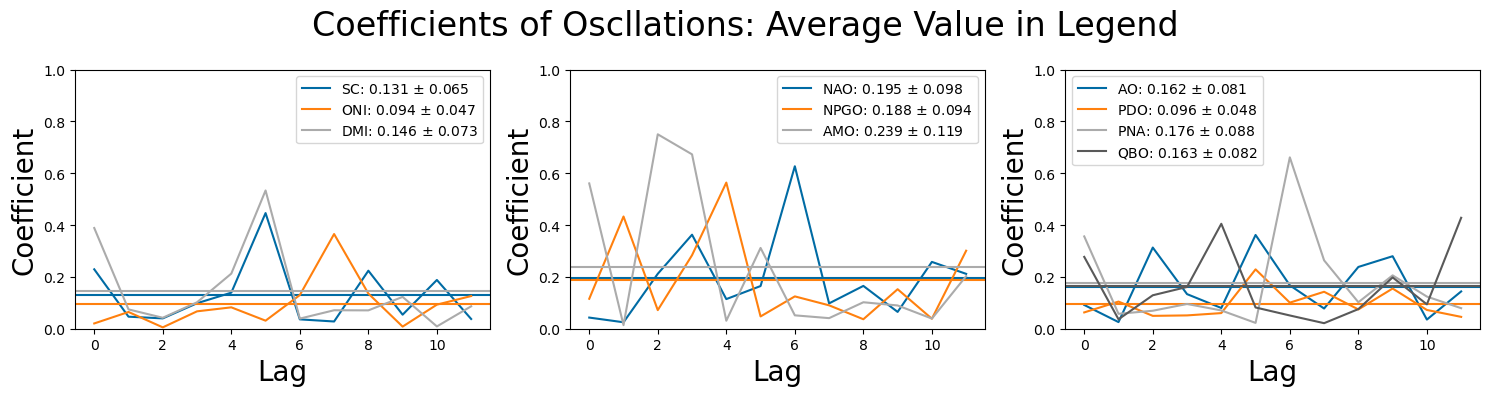

In [18]:
#plotting linear model averages
fig, ax =plt.subplots(1, 3, figsize = (15, 4))

osc_mean = []
osc_pm = []

for i in np.arange(3):
    time_mean = linear_mean[12*i:12*(i+1)].mean()
    time_pm = linear_mean[12*i:12*(i+1)].mean()/2
    
    osc_mean.append(time_mean)
    osc_pm.append(time_pm)
    
    ax[0].axhline(time_mean, color = c_list[i])
    ax[0].plot(np.arange(12), linear_mean[12*i:12*(i+1)], 
             label = osc_data_monthly.columns[i] + f': {time_mean:.3f} $\pm$ {time_pm:.3f}', color = c_list[i])

ax[0].legend(fontsize = 10)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('Lag', fontsize = 20)
ax[0].set_ylabel('Coefficient', fontsize = 20)


for i in np.arange(3)+3:
    time_mean = linear_mean[12*i:12*(i+1)].mean()
    time_pm = linear_mean[12*i:12*(i+1)].mean()/2
    
    osc_mean.append(time_mean)
    osc_pm.append(time_pm)
    
    ax[1].axhline(time_mean, color = c_list[i - 3])
    ax[1].plot(np.arange(12), linear_mean[12*i:12*(i+1)], 
             label = osc_data_monthly.columns[i] + f': {time_mean:.3f} $\pm$ {time_pm:.3f}', 
               color = c_list[i - 3])

ax[1].legend(fontsize = 10)
ax[1].set_ylim(0,1)
ax[1].set_xlabel('Lag', fontsize = 20)
ax[1].set_ylabel('Coefficient', fontsize = 20)

for i in np.arange(4)+6:
    time_mean = linear_mean[12*i:12*(i+1)].mean()
    time_pm = linear_mean[12*i:12*(i+1)].mean()/2
    
    osc_mean.append(time_mean)
    osc_pm.append(time_pm)

    ax[2].axhline(time_mean, color = c_list[i-6])
    ax[2].plot(np.arange(12), linear_mean[12*i:12*(i+1)], 
             label = osc_data_monthly.columns[i] + f': {time_mean:.3f} $\pm$ {time_pm:.3f}', 
               color = c_list[i-6])

ax[2].legend(fontsize = 10)
ax[2].set_ylim(0,1)
ax[2].set_xlabel('Lag', fontsize = 20)
ax[2].set_ylabel('Coefficient', fontsize = 20)

plt.suptitle('Coefficients of Oscllations: Average Value in Legend', fontsize = 24)
plt.tight_layout()
plt.savefig('report_figures/coefs_vs_time.png')

In [19]:
#order of oscillations
osc_order = np.flip(np.argsort(np.asarray(osc_mean)))

In [20]:
#printing oscillations in order
for i in np.arange(10):
    idx = osc_order[i]
    print(f'{osc_data_monthly.columns[idx]}: {osc_mean[idx]:.3f} +/- {osc_pm[idx]:.3f}')

AMO: 0.239 +/- 0.119
NAO: 0.195 +/- 0.098
NPGO: 0.188 +/- 0.094
PNA: 0.176 +/- 0.088
QBO: 0.163 +/- 0.082
AO: 0.162 +/- 0.081
DMI: 0.146 +/- 0.073
SC: 0.131 +/- 0.065
PDO: 0.096 +/- 0.048
ONI: 0.094 +/- 0.047


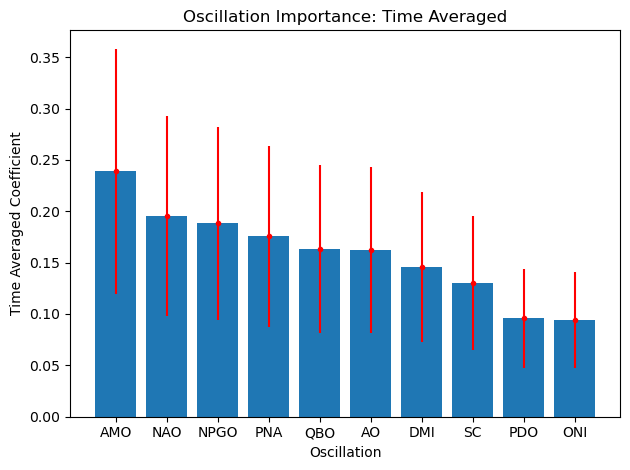

In [21]:
fig, ax = plt.subplots()

ax.bar(np.arange(10), np.asarray(osc_mean)[osc_order])
ax.errorbar(np.arange(10), np.asarray(osc_mean)[osc_order], np.asarray(osc_pm)[osc_order], c = 'r',
             ls = 'none', marker = '.')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(list(osc_data_monthly.columns[osc_order]))
ax.set_xlabel('Oscillation')
ax.set_ylabel('Time Averaged Coefficient')
plt.title('Oscillation Importance: Time Averaged')
plt.tight_layout()
plt.savefig('report_figures/osc_importance.png')

In [22]:
#arranging into a DataFrame
coefs_DF = pd.DataFrame(data = np.array([linear_mean]), columns=lagged_DF.columns)

In [23]:
#finding strong predictors for each month
for j in np.arange(12):
    x = np.zeros(10)
    for i in np.arange(10):
        x[i] = coefs_DF[coefs_DF.columns[12*i + j]]
    print(j)
    print(osc_data_monthly.columns[np.where(x > .3)[0]])
    #print(coefs_DF.columns[x > .3])

0
Index(['DMI', 'AMO', 'PNA'], dtype='object')
1
Index(['NPGO'], dtype='object')
2
Index(['AMO', 'AO'], dtype='object')
3
Index(['NAO', 'AMO'], dtype='object')
4
Index(['NPGO', 'QBO'], dtype='object')
5
Index(['SC', 'DMI', 'AMO', 'AO'], dtype='object')
6
Index(['NAO', 'PNA'], dtype='object')
7
Index(['ONI'], dtype='object')
8
Index([], dtype='object')
9
Index([], dtype='object')
10
Index([], dtype='object')
11
Index(['NPGO', 'QBO'], dtype='object')


In [24]:
#getting Fall predictors
for i in np.arange(10):
    x = coefs_DF[coefs_DF.columns[12*i + 1: 12*i + 4]].to_numpy().mean()
    if x > .3:
        print(osc_data_monthly.columns[i])

AMO


In [25]:
#getting Summer predictors
for i in np.arange(10):
    x = coefs_DF[coefs_DF.columns[12*i + 4: 12*i + 7]].to_numpy().mean()
    if x > .25:
        print(osc_data_monthly.columns[i])

DMI
NAO
PNA


In [26]:
#getting Spring predictors
for i in np.arange(10):
    x = coefs_DF[coefs_DF.columns[12*i + 7: 12*i + 10]].to_numpy().mean()
    if x > .25:
        print(osc_data_monthly.columns[i])

In [27]:
#getting last winter predictors
for i in np.arange(10):
    x = coefs_DF[coefs_DF.columns[12*i + 10: 12*i + 12]].to_numpy().mean()
    if x > .25:
        print(osc_data_monthly.columns[i])

QBO


In [28]:
#getting current winter predictors
for i in np.arange(10):
    x = coefs_DF[coefs_DF.columns[12*i]].to_numpy().mean()
    if x > .25:
        print(osc_data_monthly.columns[i])

DMI
AMO
PNA
QBO


# Making an ROC Curve

In [29]:
#finding best sliding window size for data
LogReg_window = n_train[np.argmax(accuracy_LogReg)]
Lasso_window = n_train[np.argmax(accuracy_Lasso)]
Ridge_window = n_train[np.argmax(accuracy_Ridge)]

In [30]:
#function to get metrics for models
def get_roc(model, y_clusters, n_train):    
    #list for metrics
    tprs = []
    aucs = []
    
    n_test = int(n_train/4)
    
    mean_fpr = np.linspace(0, 1, 100)
    
    #going through data
    for start_idx in range(len(X_lagged) - n_train - n_test):
        #getting training and testing data
        X_train = X_lagged[start_idx:start_idx + n_train]
        y_train = y_clusters[start_idx:start_idx + n_train]
        X_test = X_lagged[start_idx + n_train: start_idx + n_test + n_train]
        y_test = y_clusters[start_idx + n_train: start_idx + n_test + n_train]

        #fitting model and making predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        
        if np.unique(y_test).shape[0] > 1:
            auc = roc_auc_score(y_test, y_pred)
            aucs.append(auc)

        # Interpolate TPR and add the result to `tprs`
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
    return np.nanmean(np.asarray(tprs), axis = 0), np.nanmean(np.asarray(aucs))

In [31]:
#getting ROC curves
LogReg_tprs, LogReg_aucs = get_roc(LogisticRegression(), y_clusters2, LogReg_window)
Lasso_tprs, Lasso_aucs = get_roc(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), y_clusters2, Lasso_window)
Ridge_tprs, Ridge_aucs = get_roc(RidgeClassifier(), y_clusters2, Ridge_window)

/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/dzetterb/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningle

In [32]:
#print model metrics
print('Logistic Regression:')
print(f'Accuracy: {accuracy_LogReg[np.argmax(accuracy_LogReg)]}')
print(f'Precision: {precision_LogReg[np.argmax(accuracy_LogReg)]}')
print(f'Recall: {recall_LogReg[np.argmax(accuracy_LogReg)]}')
print(f'f1: {f1_LogReg[np.argmax(accuracy_LogReg)]}')
print(f'AUC: {LogReg_aucs}')

Logistic Regression:
Accuracy: 0.7032520325203252
Precision: 0.7357723577235773
Recall: 0.6914634146341463
f1: 0.6878594305423574
AUC: 0.6495614035087719


In [33]:
#print model metrics
print('Ridge:')
print(f'Accuracy: {accuracy_Ridge[np.argmax(accuracy_Ridge)]}')
print(f'Precision: {precision_Ridge[np.argmax(accuracy_Ridge)]}')
print(f'Recall: {recall_Ridge[np.argmax(accuracy_Ridge)]}')
print(f'f1: {f1_Ridge[np.argmax(accuracy_Ridge)]}')
print(f'AUC: {Ridge_aucs}')

Ridge:
Accuracy: 0.6746031746031746
Precision: 0.7787037037037038
Recall: 0.6573412698412701
f1: 0.7017857142857145
AUC: 0.648095238095238


In [34]:
#print model metrics
print('Lasso:')
print(f'Accuracy: {accuracy_Lasso[np.argmax(accuracy_Lasso)]}')
print(f'Precision: {precision_Lasso[np.argmax(accuracy_Lasso)]}')
print(f'Recall: {recall_Lasso[np.argmax(accuracy_Lasso)]}')
print(f'f1: {f1_Lasso[np.argmax(accuracy_Lasso)]}')
print(f'AUC: {Lasso_aucs}')

Lasso:
Accuracy: 0.6547619047619049
Precision: 0.8195767195767196
Recall: 0.7033730158730159
f1: 0.7207251082251082
AUC: 0.617857142857143


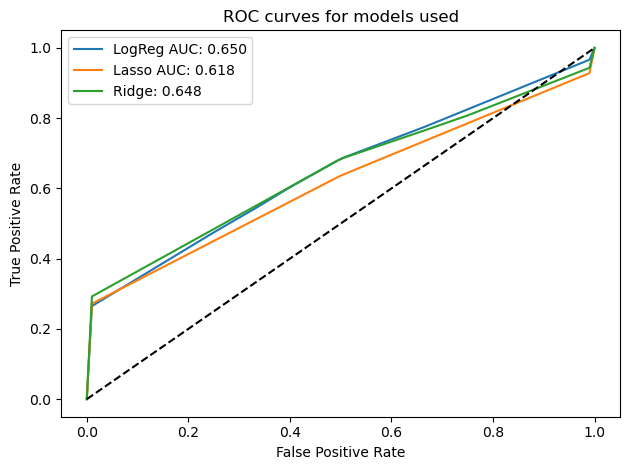

In [35]:
#plotting ROC curves
mean_fpr = np.linspace(0, 1, 100)

plt.plot(mean_fpr, LogReg_tprs, label = f'LogReg AUC: {LogReg_aucs:.3f}')
plt.plot(mean_fpr, Lasso_tprs, label = f'Lasso AUC: {Lasso_aucs:.3f}')
plt.plot(mean_fpr, Ridge_tprs, label = f'Ridge: {Ridge_aucs:.3f}')

plt.plot([0,1],[0,1],ls = '--',c = 'k')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for models used')
plt.tight_layout()
plt.savefig('report_figures/ROC_curves.png')

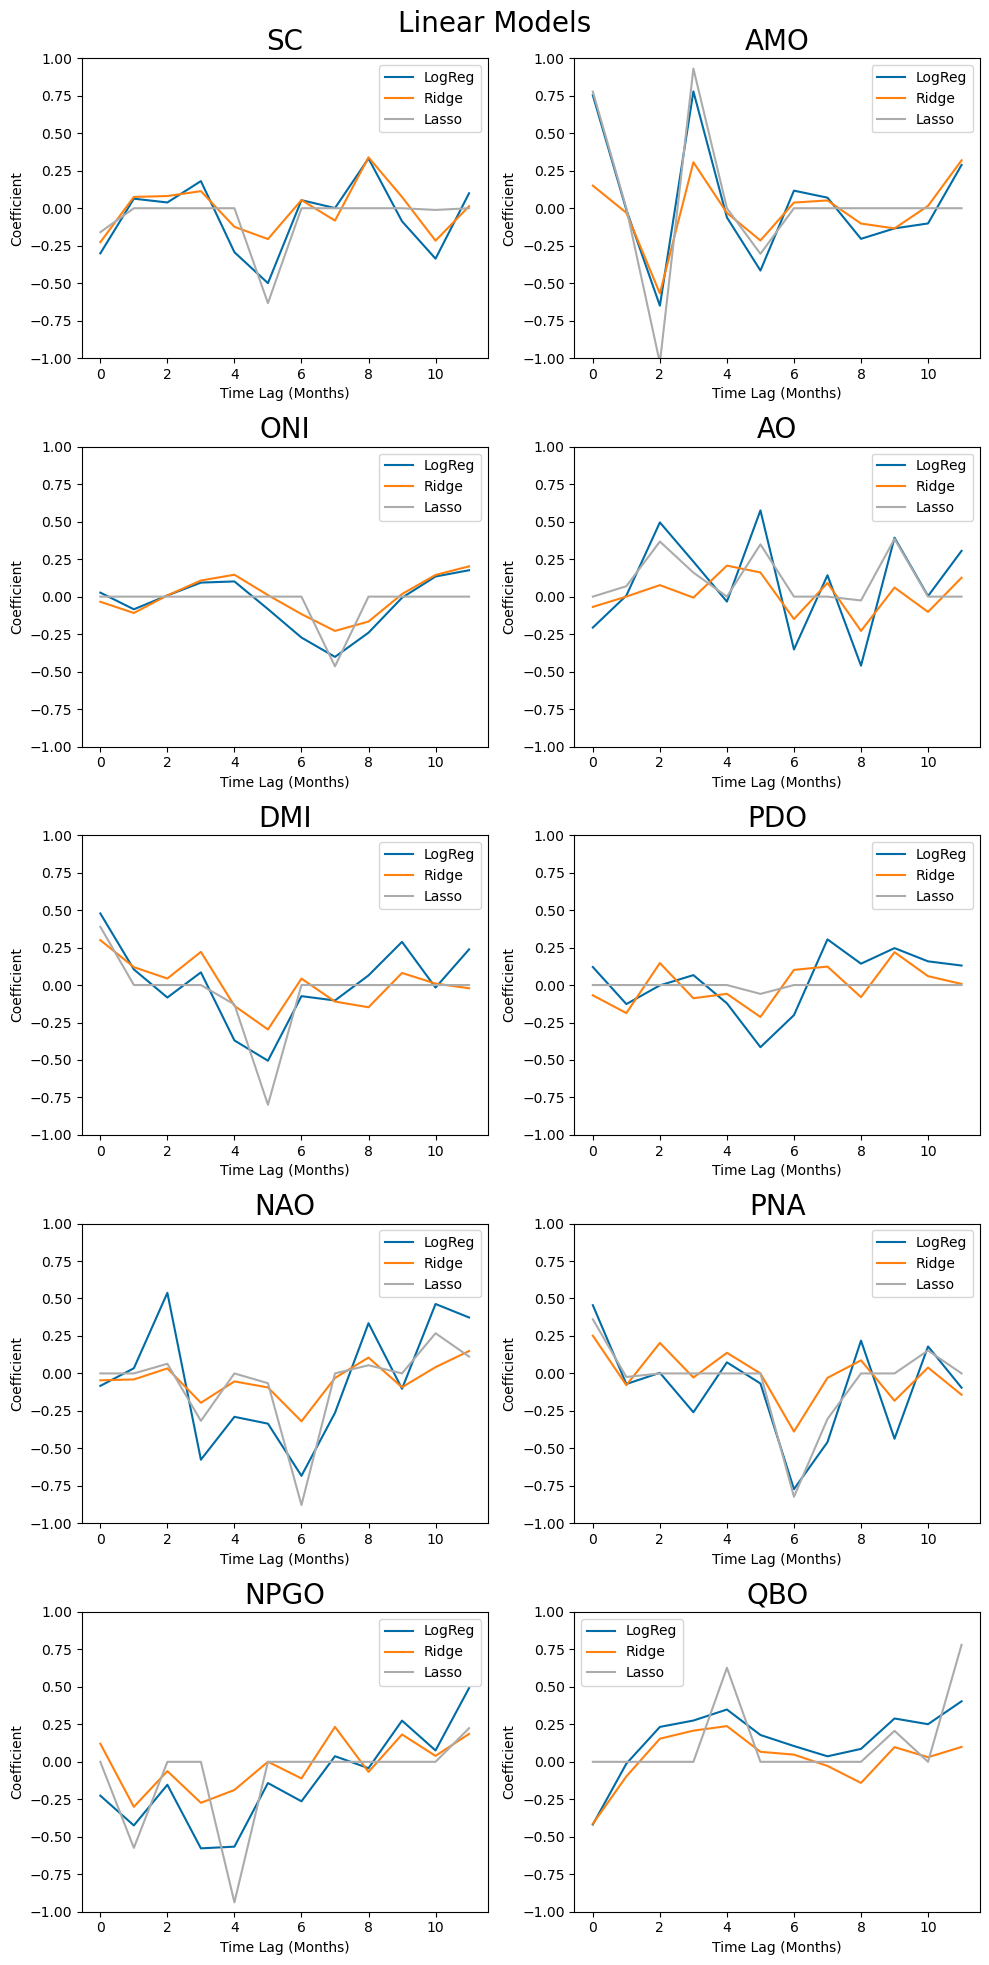

In [36]:
#plotting linear model coefficients
fig, ax = plt.subplots(5, 2, figsize = (10, 20))

for i in np.arange(10):
    for j in np.arange(3):
        ax[i%5, i//5].plot(linear_models[j][12*i:12*(i+1)], label = label_list[j], c = c_list[j])
        ax[i%5, i//5].legend()
        ax[i%5, i//5].set_xlabel('Time Lag (Months)')
        ax[i%5, i//5].set_ylabel('Coefficient')
        ax[i%5, i//5].set_title(osc_data_monthly.columns[i], fontsize = 20)
        ax[i%5, i//5].set_ylim(-1,1)
plt.suptitle('Linear Models', fontsize = 20)
plt.tight_layout()
plt.savefig('report_figures/linear_models_coef_v_time.png')

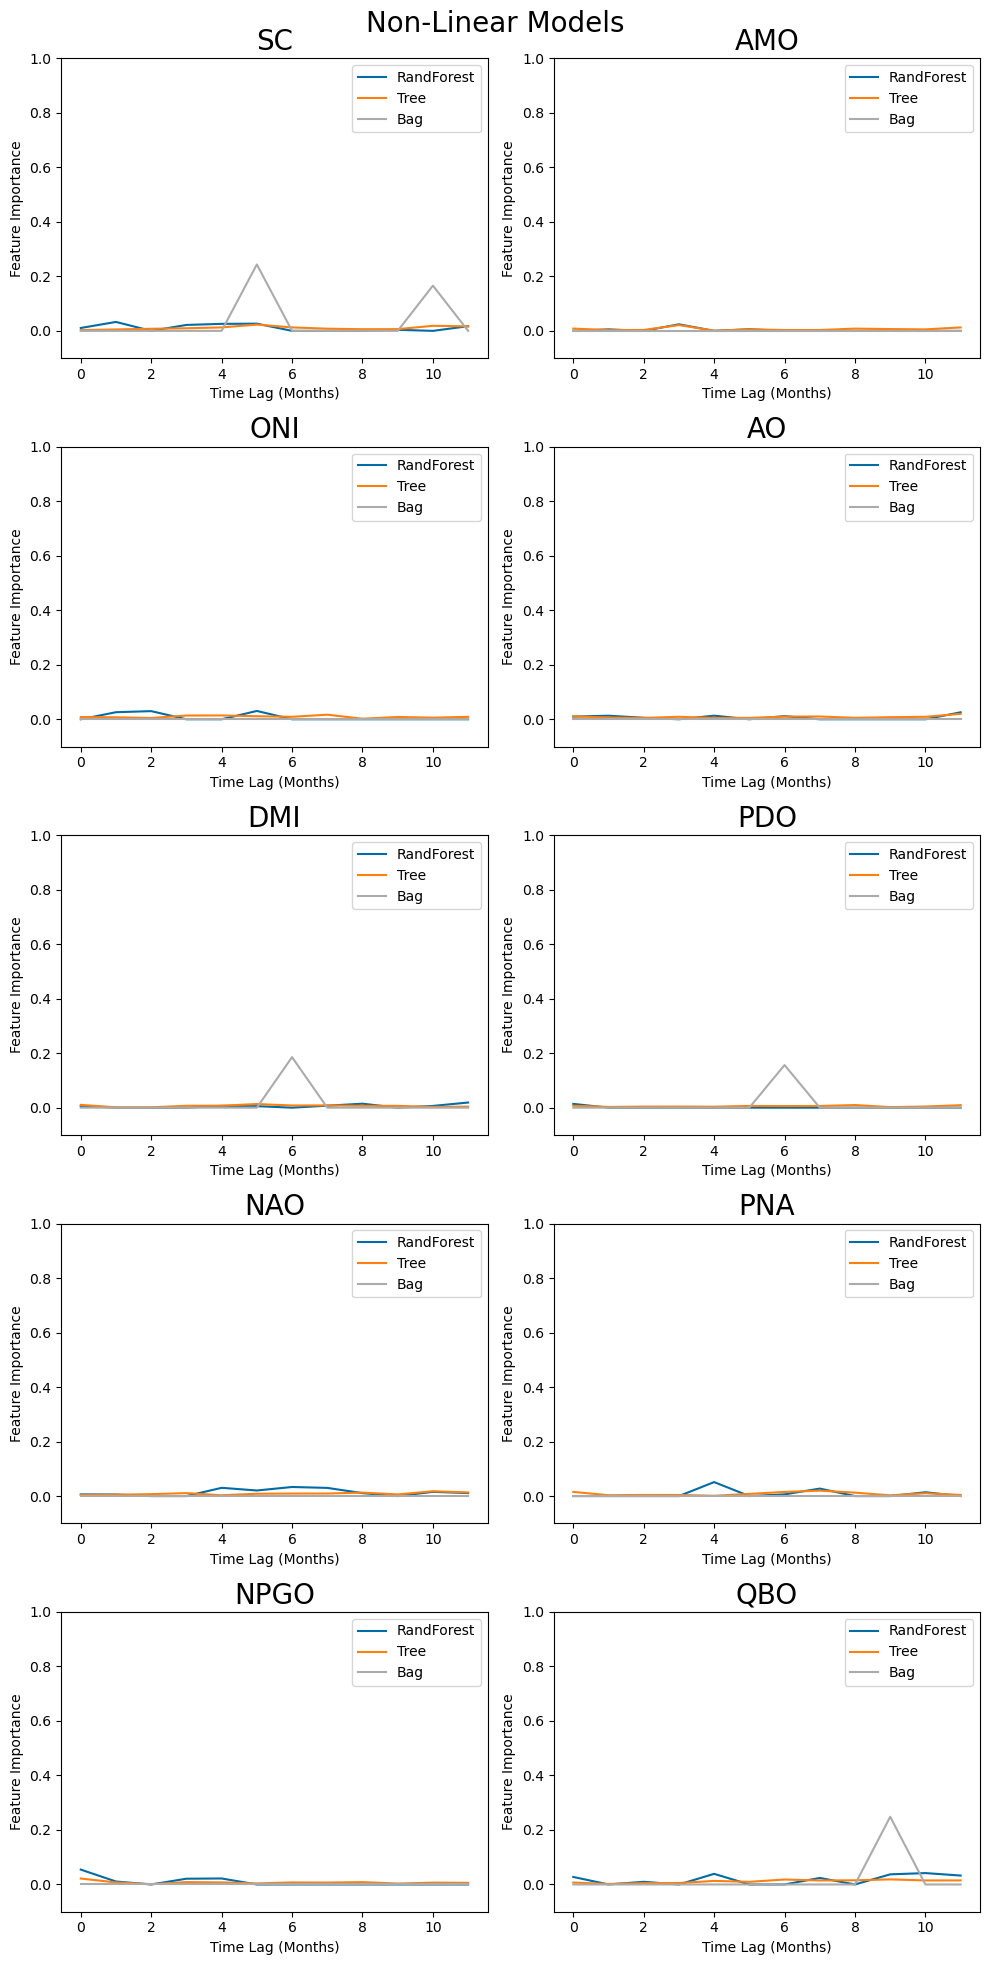

In [37]:
#plotting non-linear model feature importances
fig, ax = plt.subplots(5, 2, figsize = (10, 20))

for i in np.arange(10):
    for j in np.arange(3):
        ax[i%5, i//5].plot(nonlinear_models[j][12*i:12*(i+1)], label = label_list[j+3], c = c_list[j])
        ax[i%5, i//5].legend()
        ax[i%5, i//5].set_xlabel('Time Lag (Months)')
        ax[i%5, i//5].set_ylabel('Feature Importance')
        ax[i%5, i//5].set_title(osc_data_monthly.columns[i], fontsize = 20)
        ax[i%5, i//5].set_ylim(-.1,1)
plt.suptitle('Non-Linear Models', fontsize = 20)
plt.tight_layout()
plt.savefig('report_figures/non_linear_models_coef_v_time.png')